In [60]:
from typing import Annotated, TypedDict, List
import os
import requests
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import gradio as gr
import traceback

# === Load env ===
load_dotenv(override=True)

pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push_tool(msg: str) -> str:
    try:
        requests.post(pushover_url, data={"token": pushover_token, "user": pushover_user, "message": msg})
        return "✅ Push notification sent."
    except Exception as e:
        return f"❌ Failed to send push: {str(e)}"

# === State ===
class State(TypedDict):
    messages: Annotated[List[dict], add_messages]
    intent: str
    push_text: str

# === LLM ===
llm = ChatOpenAI(
    model="mistralai/mixtral-8x7b-instruct",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("ROUTER_API_KEY"),
)

# === Nodes ===
def llm_node(state: State) -> State:
    system_prompt = {
        "role": "system",
        "content": (
            "You are a helpful assistant. If the user wants you to send a push notification, "
            "extract the exact message they want to send and reply ONLY with that message. "
            "Otherwise, respond normally."
        )
    }
    messages = [system_prompt] + state["messages"]
    response = llm.invoke(messages)

    # Store response as dict
    state["messages"].append({"role": "assistant", "content": response.content})

    # Check if user asked to push
    last_user_msg = state["messages"][-2]["content"].lower()
    if "push" in last_user_msg or "notifica" in last_user_msg:
        state["intent"] = "push"
        state["push_text"] = response.content.strip()
    else:
        state["intent"] = "end"
    return state

def push_node(state: State) -> State:
    result = push_tool(state["push_text"])
    state["messages"].append({"role": "tool", "name": "send_push_notification", "content": result})
    return state

def router(state: State) -> str:
    return state["intent"]

# === Graph ===
graph_builder = StateGraph(State)
graph_builder.add_node("llm", llm_node)
graph_builder.add_node("push", push_node)
graph_builder.add_node("router", router)

graph_builder.set_entry_point("llm")
graph_builder.add_edge("llm", "router")
graph_builder.add_conditional_edges("router", router, {
    "push": "push",
    "end": END
})
graph_builder.add_edge("push", END)

graph = graph_builder.compile()

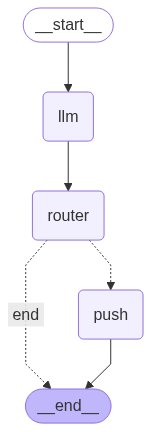

In [61]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:
# === Gradio UI ===
def chat(user_input: str, history):
    try:
        messages = [{"role": "user", "content": user_input}]
        result = graph.invoke({"messages": messages, "intent": "", "push_text": ""})
        return result["messages"][-1]["content"]
    except Exception as e:
        traceback.print_exc()
        return f"❌ Error: {str(e)}"

In [63]:
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "/var/folders/q3/zw37twcs0938w_n3bzj65f9m0000gn/T/ipykernel_54384/119586107.py", line 5, in chat
    result = graph.invoke({"messages": messages, "intent": "", "push_text": ""})
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/vpb/.pyenv/versions/genai12/lib/python3.12/site-packages/langgraph/pregel/__init__.py", line 2719, in invoke
    for chunk in self.stream(
                 ^^^^^^^^^^^^
  File "/Users/vpb/.pyenv/versions/genai12/lib/python3.12/site-packages/langgraph/pregel/__init__.py", line 2436, in stream
    for _ in runner.tick(
             ^^^^^^^^^^^^
  File "/var/folders/q3/zw37twcs0938w_n3bzj65f9m0000gn/T/ipykernel_54384/1367391868.py", line 55, in llm_node
    last_user_msg = state["messages"][-2]["content"].lower()
                    ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
TypeError: 'HumanMessage' object is not subscriptable
During task with name 'llm' and id 'c54cd5dd-291d-29e1-8f5f-f